# Examples of using inrad reader
This is a quick notebook documenting some examples of how to use the inrad reader to convert to CF/Radial files as well as gridding these using pyart. 

In [1]:
%matplotlib inline

from inrad_reader import inrad_to_cf
import matplotlib.pyplot as plt

import pyart

## Reading in files and gridding.
This is the programmatic way to read in and grid files using this tool. A similar process is done by the inrad_to_cf tool bundled with this library. The main portion is orchestrated by the `inrad_to_cf.read_multi_radar` call. You pass this a regex to collect all files in one volumn and it will piece together the files and then create a `pyart.Radar` object. 

In [2]:
test_file_path_DEM = '/Volumes/hard_lacie_hfs/data/indian_radar_data/DEMS/'
test_file_path_VANP = '/Volumes/hard_lacie_hfs/data/indian_radar_data/VANP/'

In [48]:
radar = inrad_to_cf.read_multi_radar(test_file_path_DEM + 'T_HAHA00_C_DEMS_20180828053230_*.nc')

At this point we have a pyart radar object. We can do normal things like pass this to plotting routines. 

In [49]:
display = pyart.graph.RadarDisplay(radar)

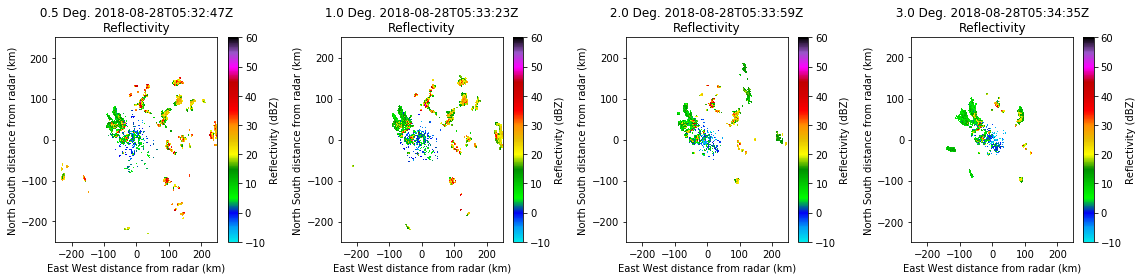

In [59]:
varname = 'reflectivity'
sweep_start = 0
vmin=-10
vmax=60
plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
display.plot(varname,sweep_start, vmin=vmin, vmax=vmax)

plt.subplot(1,4,2)
display.plot(varname,sweep_start+1, vmin=vmin, vmax=vmax)

plt.subplot(1,4,3)
display.plot(varname,sweep_start+2, vmin=vmin, vmax=vmax)

plt.subplot(1,4,4)
display.plot(varname,sweep_start+3, vmin=vmin, vmax=vmax)

plt.tight_layout()

Now we can write the file out to a CF/Radial(ish) netcdf file. 

In [6]:
pyart.io.write_cfradial('test.nc', radar)

## Gridding
This is a (very) brief example on gridding. The performance is not particularly tuned to this radar and there are better assortments of parameters, but this will show the general idea. 

In [51]:
grid = pyart.map.grid_from_radars(radar, grid_shape = (10,400,400), grid_limits=((0,5000),(-250000,250000), (-250000,250000)), fields=('reflectivity','differential_reflectivity'),
                                  )

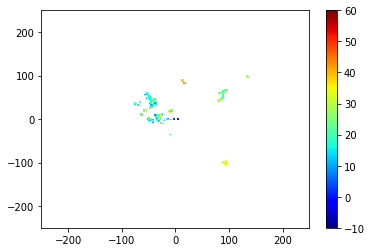

In [68]:
height = 3
plt.pcolormesh(grid.x['data']/1000.0, grid.y['data']/1000.0, grid.fields[varname]['data'][height,:,:], vmin=vmin,  vmax=vmax, cmap='jet')
plt.colorbar()

In [9]:
radar.fields.keys()

dict_keys(['total_power', 'reflectivity', 'mean_doppler_velocity', 'spectrum_width', 'differential_reflectivity', 'specific_differential_phase', 'differential_phase', 'normalized_coherent_power', 'copol_correlation_coeff', 'hydrometeor_classification'])

In [ ]:
display = pyart.graph.GridMapDisplay(grid)

## VANP radar tests
We'll also test the other radar data we were sent single pol to make sure it works as well. 

In [13]:
radar_VANP = inrad_to_cf.read_multi_radar(test_file_path_VANP + 'T_HAHA00_C_VANP_20180706104202*.nc')
print(f"Included fields are {radar_VANP.fields.keys()}")

Included fields are dict_keys(['total_power', 'reflectivity', 'mean_doppler_velocity', 'spectrum_width'])


In [11]:
display_VANP = pyart.graph.RadarDisplay(radar_VANP)

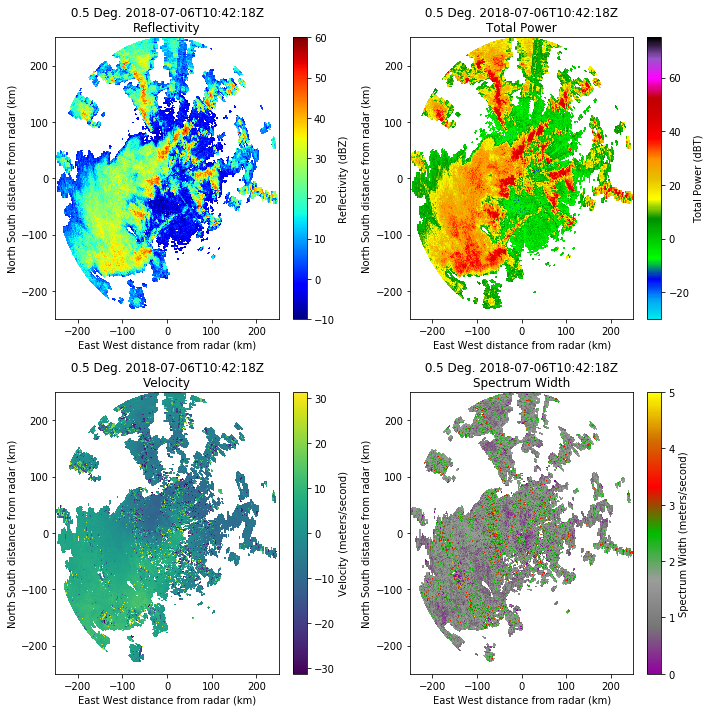

In [75]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
display_VANP.plot('reflectivity',0, cmap='jet', vmin=vmin,  vmax=vmax)

plt.subplot(2,2,2)
display_VANP.plot('total_power',0)

plt.subplot(2,2,3)
display_VANP.plot('mean_doppler_velocity',0)

plt.subplot(2,2,4)
display_VANP.plot('spectrum_width',0, vmin=0, vmax=5)

plt.tight_layout()

In [93]:
gatefilter = pyart.filters.GateFilter(radar_VANP)
gatefilter.include_all()
grid_VANP = pyart.map.grid_from_radars(radar_VANP, grid_shape = (10,400,400), grid_limits=((0,5000),(-250000,250000), (-250000,250000)), fields=('reflectivity','spectrum_width'),
                                       gatefilter=gatefilter, weighting_function='Cressman', roi_func='dist'
                                  )

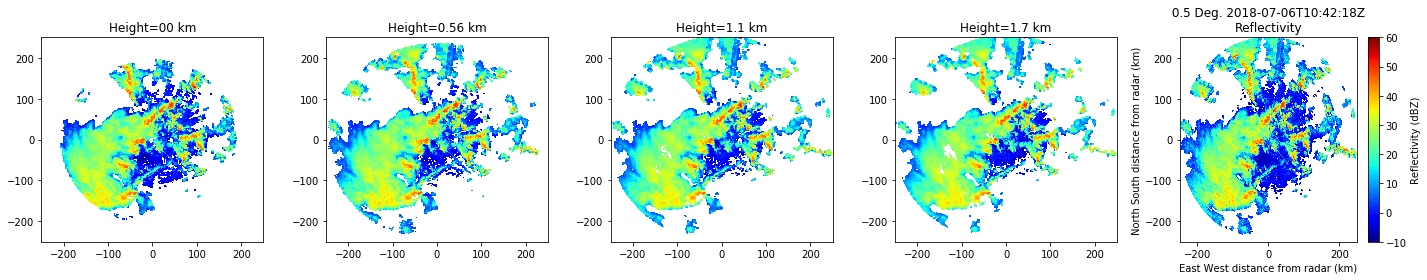

In [109]:
varname = 'reflectivity'
height = 0
vmin=-10
vmax=60
plt.figure(figsize=(20,4))

plt.subplot(1,5,1)
plt.pcolormesh(grid_VANP.x['data']/1000.0, grid_VANP.y['data']/1000.0, grid_VANP.fields[varname]['data'][height,:,:], vmin=vmin,  vmax=vmax, cmap='jet')
plt.title(f"Height={grid.z['data'][height+0]/1000:02.2g} km")

plt.subplot(1,5,2)
plt.pcolormesh(grid_VANP.x['data']/1000.0, grid_VANP.y['data']/1000.0, grid_VANP.fields[varname]['data'][height+1,:,:], vmin=vmin,  vmax=vmax, cmap='jet')
plt.title(f"Height={grid.z['data'][height+1]/1000:02.2g} km")

plt.subplot(1,5,3)
plt.pcolormesh(grid_VANP.x['data']/1000.0, grid_VANP.y['data']/1000.0, grid_VANP.fields[varname]['data'][height+2,:,:], vmin=vmin,  vmax=vmax, cmap='jet')
plt.title(f"Height={grid.z['data'][height+2]/1000:02.2g} km")

plt.subplot(1,5,4)
plt.pcolormesh(grid_VANP.x['data']/1000.0, grid_VANP.y['data']/1000.0, grid_VANP.fields[varname]['data'][height+3,:,:], vmin=vmin,  vmax=vmax, cmap='jet')
plt.title(f"Height={grid.z['data'][height+3]/1000:02.2g} km")

plt.subplot(1,5,5)
display_VANP.plot('reflectivity',0, cmap='jet', vmin=vmin,  vmax=vmax)

plt.tight_layout()

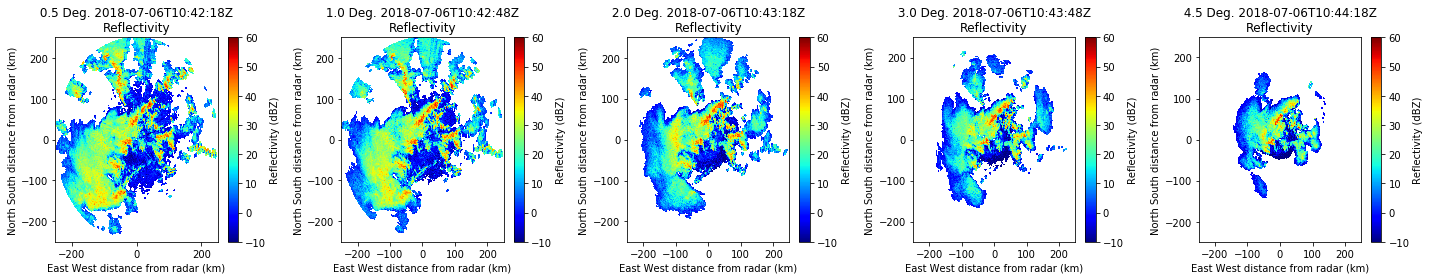

In [89]:
plt.figure(figsize=(20,4))
plt.subplot(1,5,1)
display_VANP.plot('reflectivity',0, cmap='jet', vmin=vmin,  vmax=vmax)

plt.subplot(1,5,2)
display_VANP.plot('reflectivity',1, cmap='jet', vmin=vmin,  vmax=vmax)

plt.subplot(1,5,3)
display_VANP.plot('reflectivity',2, cmap='jet', vmin=vmin,  vmax=vmax)

plt.subplot(1,5,4)
display_VANP.plot('reflectivity',3, cmap='jet', vmin=vmin,  vmax=vmax)

plt.subplot(1,5,5)
display_VANP.plot('reflectivity',4, cmap='jet', vmin=vmin,  vmax=vmax)

plt.tight_layout()